In [1]:
using Distributions
using Random
using Plots

In [2]:
function draw_dirichlet_multinomial(n::Integer, α::Vector{T1}, T::Real, K::Integer) where {T1 <: Real}
    cdf = DirichletMultinomial(n, T .* α ./ sum(α))
    return rand(cdf, K)
end

draw_dirichlet_multinomial (generic function with 1 method)

In [3]:
K = 3
p = [0.7, 0.2, 0.1]
T = 0.5
Xk = draw_dirichlet_multinomial(10, p, T, 10000)

3×10000 Array{Int64,2}:
 8  10  10  10  6  10  0  2  10  8  5  …  9  10  10  8  10   0  9  2  9   0
 0   0   0   0  0   0  9  0   0  2  5     1   0   0  2   0  10  1  8  1  10
 2   0   0   0  4   0  1  8   0  0  0     0   0   0  0   0   0  0  0  0   0

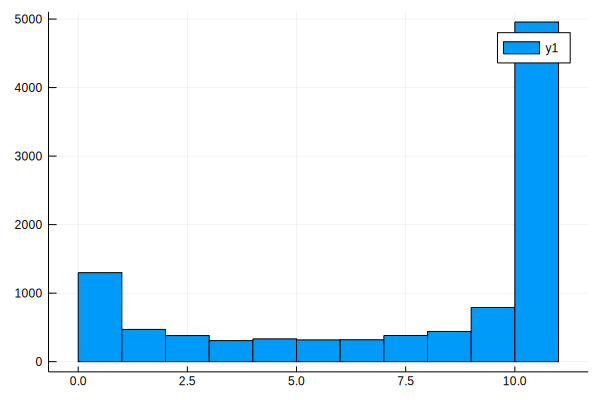

In [4]:
histogram(Xk[1,:])

In [5]:
function compute_KLD(share::Array{Float64,N}, p::Vector{Float64}) where {N}
    all(sum(share, dims=1) .≈ 1) || throw(ArgumentError("Shares have to sum to 1.")) 
    deviation = log.(share ./ p)
    # log(0) is fine because 0*log(0) = 0
    replace!(deviation, -Inf=>0)
    # convert to vector instead of 1xK array
    return sum(share .* deviation, dims=1)
end

compute_KLD (generic function with 1 method)

In [6]:
KLD = compute_KLD(Xk ./ sum(Xk, dims=1), p)


1×10000 Array{Float64,2}:
 0.245455  0.356675  0.356675  0.356675  …  0.858483  0.156868  1.60944

In [7]:
include("./polya.jl")
using .Polya

In [8]:
P = Polya.estimate_dirichlet_multinomial(Xk, maxiter=1000)

DirichletMultinomial{Float64}(n=100000, α=[0.3393179830032507, 0.09855926040774939, 0.050263819291581524])

In [9]:
pmf = Polya.simulate_ECDF(P, compute_KLD)

DiscreteNonParametric{Float64,Float64,Array{Float64,1},Array{Float64,1}}(
support: [2.0e-5, 3.0e-5, 0.00012, 0.0002, 0.00037, 0.00045, 0.00051, 0.00057, 0.00058, 0.00065  …  2.27279, 2.2728, 2.27285, 2.27292, 2.27296, 2.27304, 2.27307, 2.27317, 2.27319, 2.27332]
p: [1.000010000100001e-5, 1.000010000100001e-5, 1.000010000100001e-5, 1.000010000100001e-5, 1.000010000100001e-5, 1.000010000100001e-5, 1.000010000100001e-5, 1.000010000100001e-5, 1.000010000100001e-5, 1.000010000100001e-5  …  3.000030000300003e-5, 6.000060000600006e-5, 2.000020000200002e-5, 0.0001000010000100001, 1.000010000100001e-5, 0.00018000180001800017, 2.000020000200002e-5, 0.00016000160001600016, 5.000050000500005e-5, 0.0006000060000600005]
)


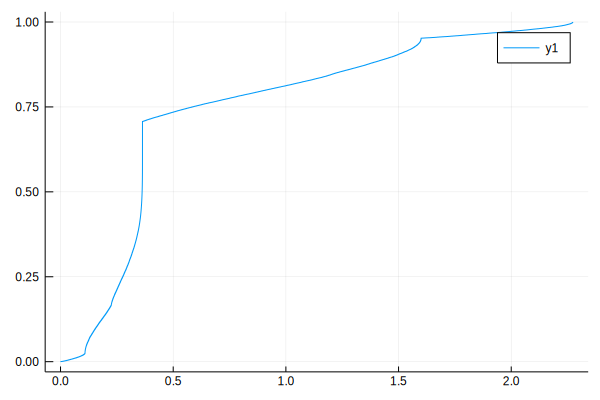

In [10]:
x = support(pmf)
p = cumsum(probs(pmf))
plot(x, p)

In [11]:
cdf(pmf, 1.0)

0.8124481244809073

In [12]:
mean(pmf)

0.5607771497714976

using CSVFiles
data = load("../temp/shipment-clean.csv")

In [13]:
function get_destination_matrix(data, country)
    cut = 3
    output = zeros(Int, (97, 0))
    for row in collect(data)
        fields = keys(row)[cut+1:end]
        if row.iso2_d == country
            output = [output zeros(Int, (length(fields), 1))]
            for (i, field) in enumerate(fields)
                output[i,end] = row[field]
            end
        end
    end
    return output
end

get_destination_matrix (generic function with 1 method)

shipments_to_russia = get_destination_matrix(data, "RU")

russia_shares = Polya.estimate_dirichlet_multinomial(shipments_to_russia, maxiter=10000)

In [14]:
function compute_p_values(data)
    K, N = size(data)
    H0_params = Polya.estimate_dirichlet_multinomial(data, maxiter=10000)
    H0_shares = H0_params.α ./ sum(H0_params.α)
    actual_KLD = compute_KLD(data ./ sum(data, dims=1), H0_shares)
    
    p = zeros(Float64, N)
    # FIXME: for testing purposes, only compute first 5 p value
    for i = 1:N
        # actual number of shipments treated as a parameter
        H1 = DirichletMultinomial(sum(data[:,i]), H0_params.α)
        pmf = Polya.simulate_ECDF(H0_params, compute_KLD)
        p[i] = 1 - cdf(pmf, actual_KLD[1,i])
    end
    return p
end

compute_p_values (generic function with 1 method)

ps = compute_p_values(shipments_to_russia)

In [15]:
size(Xk)

(3, 10000)

In [16]:
ps = compute_p_values(Xk[:,1:100])

100-element Array{Float64,1}:
 0.8074880748807561
 0.4964749647496496
 0.4949449494494965
 0.4939849398494004
 0.2955129551295571
 0.4967749677496788
 0.12280122801249926
 0.1324213242134542
 0.49290492904929206
 0.9491594915949163
 0.7209472094721048
 0.0
 0.49774497744977675
 ⋮
 0.9483294832948336
 0.4956549565495675
 0.0454104541048066
 0.49567495674957096
 0.4936949369493706
 0.7187671876718869
 0.49754497544975607
 0.49628496284963064
 0.13474134741368482
 0.9317793177931785
 0.4938049380493821
 0.8752387523875228

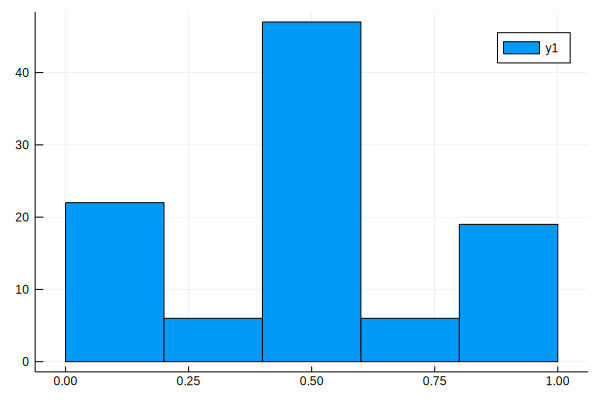

In [18]:
histogram(ps)